# Graded Challenge 7 - Food Classification (CNN)

**Notes**

Mohon maaf untuk urutan shell yang dijalankan yang sedikit kurang berurutan dikarenakan perlu dilakukan re-iterasi untuk setiap model yang dijalankan (dikarenakan kapasitas GPU dari colab yang timeout) dikarenakan menjalankan keseluruhan notebook dalam 1 iterasi tidak memungkinkan (terlalu lama dan sudah habis free GPU dari colabnya). Terima kasih atas pehatiannya!

## Perkenalan

Nama : Vania Alya Qonita <br>
Batch : RMT 029 <br>
<br>

Latar belakang : Tingkat obesitas pada Indonesia telah meningkat menjadi 21,8%. Salah satu kunci dalam berat badan yang sehat adalah mencukupi dan menyeimbangkan jumlah kalori yang diterima oleh tubuh. Oleh karena itu, kita akan mencoba membuat sebuah kalori tracking dengan pendeteksian jenis makanan yang dimakan oleh user.

Tujuan : Membuat model CNN untuk dapat melakukan klasifikasi terhadap gambar makanan.

## Import Libraries

In [ ]:
# Melakukan import libraries yang akan digunakan
import os
import glob
from pathlib import Path
import pandas as pd
from scipy import stats
import numpy as np
# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
# Library untuk data loading
import zipfile

# Sklearn library
from sklearn.metrics import classification_report
# Untuk melakukan splitting data
from sklearn.model_selection import train_test_split

# Tensorflow library untuk deep learning
# Untuk plotting model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# Untuk menggenerasi image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Untuk membuat hidden layer, convolution layer, pooling, dan flatten
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Flatten
# Untuk callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Loading
Melakukan data loading menggunakan API key dari kaggle. Mohon siapkan kaggle API file untuk dilakukan uploading pada proses ini.

Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [ ]:
# Melakukan installing kaggle
! pip install -q kaggle

In [ ]:
# Upload kaggle API file disini
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fluffyroo","key":"6e036836252276f078bae672f9e36f94"}'}

In [ ]:
# Membuat directory bernama kaggle dan melakukan copy file kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
# Merubah permission dari file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Mendownload data Uber and Lyft dataset
!kaggle datasets download -d bjoernjostein/food-classification

100% 751M/753M [00:22<00:00, 44.6MB/s]
100% 753M/753M [00:22<00:00, 34.9MB/s]


In [ ]:
# Dikarenakan data yang di download dalam bentuk ZIP, maka kita lakukan unzip pada data
zip_ref = zipfile.ZipFile('food-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Mengambil path untuk setiap file
train_dir = '/content/train_images/train_images'
test_dir = '/content/test_images/test_images'

In [ ]:
# Load data yang telah di extract ke dalam dataframe
train_df = pd.read_csv('train_img.csv')
# Menampilkan data pada train_df
train_df.head()

ImageId               ClassName
0  f27632d7e5.jpg                   water
1  efa87919ed.jpg  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg

In [ ]:
# Mendefinisikan class names
class_names = train_df['ClassName'].unique().tolist()

In [ ]:
# Menambahkan kolom path image
train_df['ImagePath'] = '/content/train_images/train_images/' + train_df['ImageId']
# Melihat hasil penambahan kolom
train_df.head()

ImageId               ClassName  \
0  f27632d7e5.jpg                   water   
1  efa87919ed.jpg  pizza-margherita-baked   
2  4f169e8c8d.jpg                broccoli   
3  a6956654bf.jpg  salad-leaf-salad-green   
4  d99ce8c3bf.jpg                     egg   

                                           ImagePath  
0  /content/train_images/train_images/f27632d7e5.jpg  
1  /content/train_images/train_images/efa87919ed.jpg  
2  /content/train_images/train_images/4f169e8c8d.jpg  
3  /content/train_images/train_images/a6956654bf.jpg  
4  /content/train_images/train_images/d99ce8c3bf.jpg

In [ ]:
# Melihat tipe data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9323 entries, 0 to 9322
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageId    9323 non-null   object
 1   ClassName  9323 non-null   object
 2   ImagePath  9323 non-null   object
dtypes: object(3)
memory usage: 218.6+ KB


## Exploratory Data Analysis (EDA)
Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

### Data Understanding

In [ ]:
# Melihat jumlah train_df
train_df.shape

(9323, 3)

In [ ]:
# Melihat unique values dari class
print(f"Jumlah kelas yang tersedia adalah : {len(train_df['ClassName'].unique())}")
print(f"Nama kelas yang tersedia adalah : {train_df['ClassName'].unique()}")

Jumlah kelas yang tersedia adalah : 61
Nama kelas yang tersedia adalah : ['water' 'pizza-margherita-baked' 'broccoli' 'salad-leaf-salad-green'
 'egg' 'butter' 'bread-white' 'apple' 'dark-chocolate'
 'white-coffee-with-caffeine' 'sweet-pepper'
 'mixed-salad-chopped-without-sauce' 'tomato-sauce' 'cucumber' 'cheese'
 'pasta-spaghetti' 'rice' 'zucchini' 'salmon' 'mixed-vegetables'
 'espresso-with-caffeine' 'banana' 'strawberries' 'mayonnaise' 'almonds'
 'bread-wholemeal' 'wine-white' 'hard-cheese' 'ham-raw' 'tomato'
 'french-beans' 'mandarine' 'wine-red' 'potatoes-steamed' 'croissant'
 'carrot' 'salami' 'boisson-au-glucose-50g' 'biscuits' 'corn'
 'leaf-spinach' 'tea-green' 'chips-french-fries' 'parmesan' 'beer'
 'bread-french-white-flour' 'coffee-with-caffeine' 'chicken' 'soft-cheese'
 'tea' 'avocado' 'bread-sourdough' 'gruyere' 'sauce-savoury' 'honey'
 'mixed-nuts' 'jam' 'bread-whole-wheat' 'water-mineral' 'onion' 'pickle']


In [ ]:
# Melihat jumlah dari setiap class
JumlahKelas = pd.DataFrame(train_df['ClassName'].value_counts()).reset_index()
print(JumlahKelas.to_string())

                            ClassName  count
0                               water    863
1                         bread-white    595
2              salad-leaf-salad-green    535
3                     bread-wholemeal    398
4                coffee-with-caffeine    377
5                              tomato    358
6                              butter    346
7                              carrot    297
8                                rice    256
9                            wine-red    241
10                   mixed-vegetables    237
11                                egg    209
12             espresso-with-caffeine    195
13                              apple    191
14                             banana    181
15                                tea    177
16  mixed-salad-chopped-without-sauce    169
17                                jam    163
18                   potatoes-steamed    156
19                         wine-white    151
20                             cheese    137
21        

### Data Visualization

#### Persebaran Class

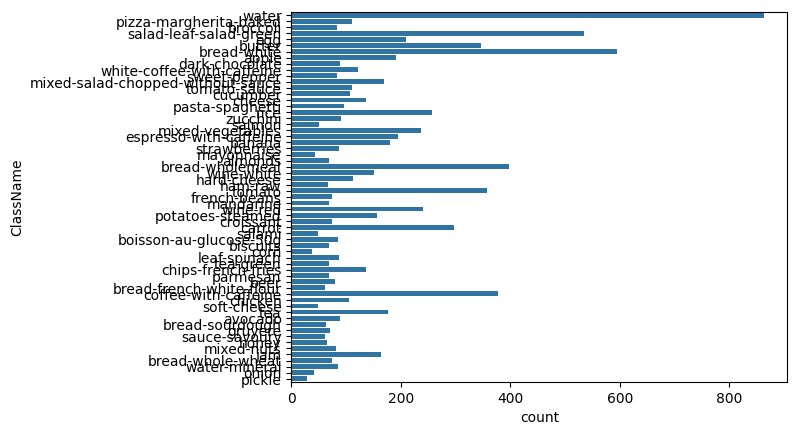

In [ ]:
# Melihat persebaran class
sns.countplot(train_df['ClassName'])
plt.show()

Dari visualisasi dapat terlihat bahwa label terbanyak dimiliki oleh label 'water' dan ter-rendah dimiliki oleh 'pickle'. Dapat terlihat bahwa persebaran kelas untuk tiap label sangat bervariasi, hal ini dapat meningkatkan bias terhadap kelas tertentu pada prediksi nantinya.

#### Contoh Gambar

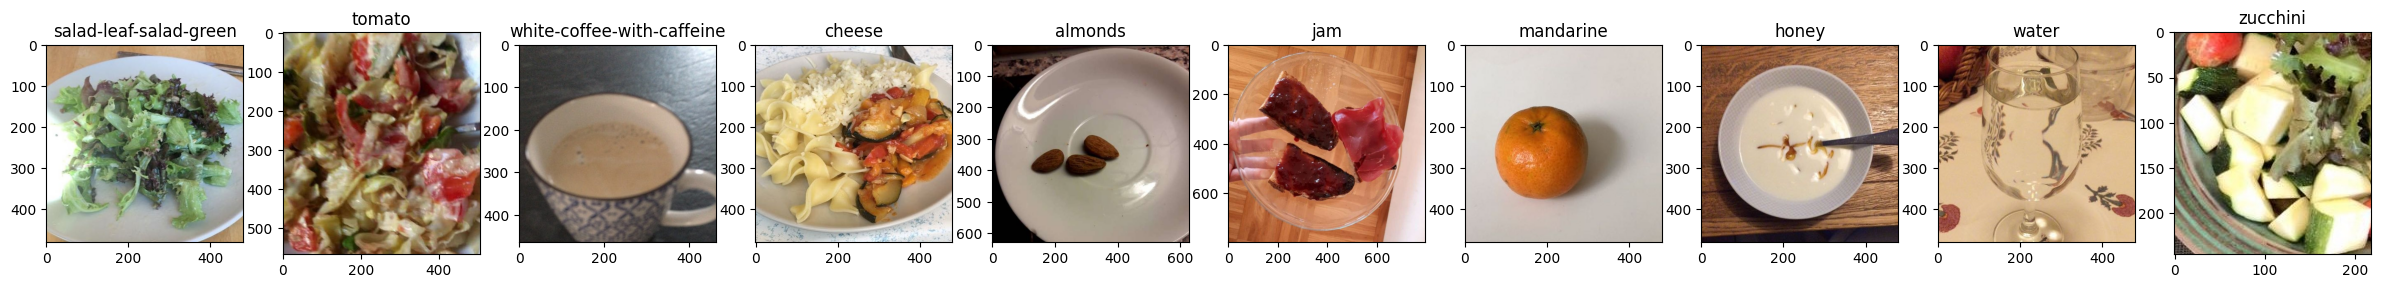

In [ ]:
# Melihat contoh image pada train

train_files = glob.glob(train_dir + "/*")
train_list = os.listdir(train_dir)
fig, ax = plt.subplots(ncols=10, figsize=(30,3))
for i in range(10):
  train_image = plt.imread(train_files[i])
  ax[i].imshow(train_image)
  ax[i].set_title(train_df[train_df['ImageId'] == train_list[i]]['ClassName'].to_string(index=False))

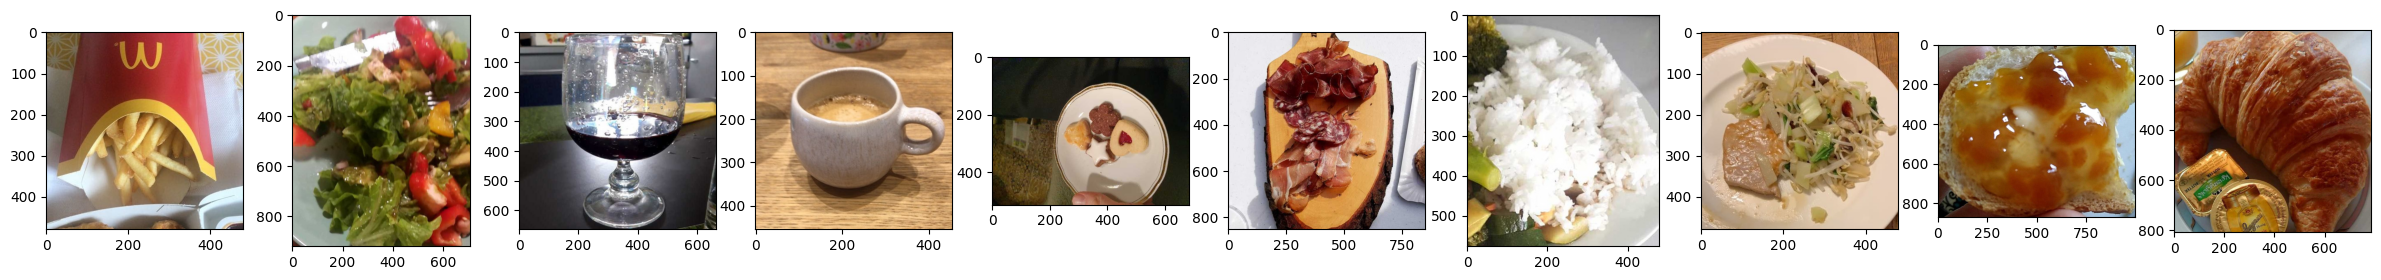

In [ ]:
# Melihat contoh image pada test

test_files = glob.glob(test_dir + "/*")
fig, ax = plt.subplots(ncols=10, figsize=(30,3))
for i in range(10):
  test_image = plt.imread(test_files[i])
  ax[i].imshow(test_image)

#### Persebaran jumlah data

Amount of images
Train : 9323
Test : 484


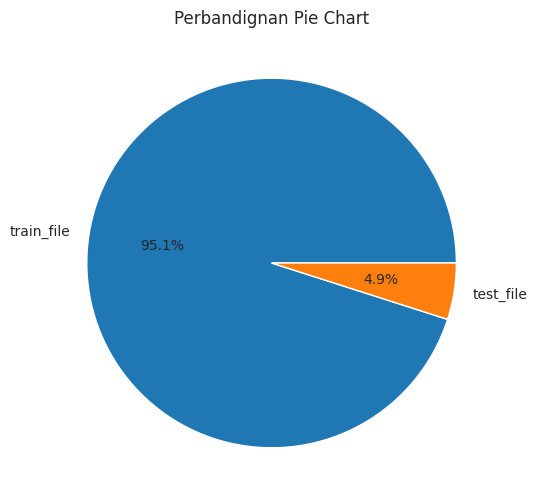

In [ ]:
# Melihat perbandingan jumlah data pada train dan test
print("Amount of images")
print("Train :", len(train_files))
print("Test :", len(test_files))

# Visualisasi
# Mempersiapkan data
data_perbandingan = {
    'labels' : ['train_file', 'test_file'],
    'values' : [len(train_files), len(test_files)]
    }
df_perbandingan = pd.DataFrame(data_perbandingan)
# Membuat visualisasi
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df_perbandingan['values'], labels=df_perbandingan['labels'], autopct='%1.1f%%')
plt.title('Perbandignan Pie Chart')
plt.show()

Kita dapat melihat bahwa pembagian untuk data adalah 4.9% untuk test dan 95.1% untuk train. Oleh karena itu, kita akan melakukan splitting data untuk test kembali dari dataset train. Data test_file yang sudah tersedia akan digunakan untuk melakukan data inference.

#### Persebaran distribusi size gambar

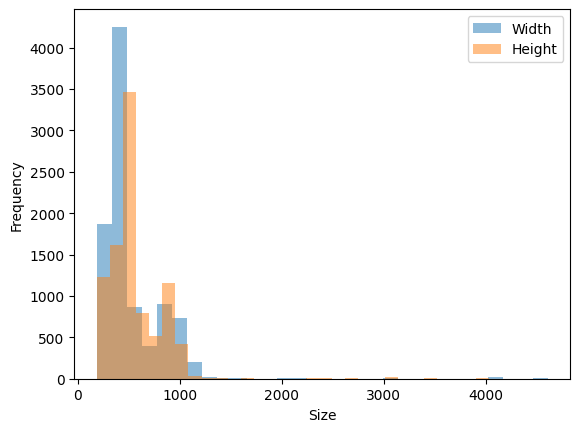

In [ ]:
# Melihat distribusi size gambar
sizes=[]
for img in train_files :
    temp_image = plt.imread(img)
    sizes.append((temp_image.shape[0], temp_image.shape[1]))
widths, heights = zip(*sizes)
plt.hist(widths, bins=30, alpha=0.5, label='Width')
plt.hist(heights, bins=30, alpha=0.5, label='Height')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Dari grafik, dapat terlihat kebanyakan gambar memiliki lebar dan panjang pada kisaran 100 - 1000 dengan terbanyak pada kisaran 400 - 500. Hal ini harus kita pertimbangkan pada proses perubahan target size dikarenakan pengurangan besar gambar yang terlalu masif dapat menghilangkan informasi dari gambar.

Dengan hal tersebut, kita akan mencoba untuk menggunakan target size sebesar 260x260.

## Feature Engineering

Pada feature engineering akan dilakukan splitting data, scaling, dan augmentasi. Ketiga hal ini dapat dilakukan dalam ImageDataGenerator sekaligus. Dimana splitting dilakukan dengan `validation_split`, scaling dengan `rescale` dan augmentasi dilakukan dengan menyesuaikan jenis augmentasi yang ingin diterapkan.

Akan dilakukan detail feature engineering sebagai beirikut.
- Splitting : Splitting 60% train dan 40% validation
- Scaling : Membagi dengan 255 sebagai range pixel dari gambar
- Augmentasi : Rotasi gambar

In [ ]:
# Melakukan split data antara Train-Set, Val-Set, and Test-Set

# Melakukan splitting train_val data dengan tes data
dat_train_val, dat_test = train_test_split(train_df, test_size=0.2, random_state=42)
# Melakukan splitting train dan validation data dari train_val data
dat_train, dat_val = train_test_split(dat_train_val, test_size=0.2, random_state=42)
# Menampilkan hasil jumlah data
print('Train Size : ', dat_train.shape)
print('Val Size   : ', dat_val.shape)
print('Test Size  : ', dat_test.shape)

Train Size :  (5966, 3)
Val Size   :  (1492, 3)
Test Size  :  (1865, 3)


In [ ]:
# Melakukan image data generator bagi 3 subset
# Mendefinsikan imange data generator dengan scaling dan rotation (augmentasi data)
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=75)
# Melakukan image data generator untuk subset train data
train_generator = datagen.flow_from_dataframe(dat_train,
                                    x_col='ImagePath',
                                    y_col='ClassName',
                                    target_size=(260,260),
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=2)

# Melakukan image data generator untuk subset validation data
val_generator = datagen.flow_from_dataframe(dat_val,
                                  x_col='ImagePath',
                                  y_col='ClassName',
                                  target_size=(260,260),
                                  class_mode='categorical',
                                  shuffle=False)

# Melakukan image data generator untuk subset test data
test_generator = datagen.flow_from_dataframe(dat_test,
                                  x_col='ImagePath',
                                  y_col='ClassName',
                                  target_size=(260,260),
                                  class_mode='categorical',
                                  shuffle=False)

Found 5966 validated image filenames belonging to 61 classes.
Found 1492 validated image filenames belonging to 61 classes.
Found 1865 validated image filenames belonging to 61 classes.


In [ ]:
# Melihat hasil indices dari kelas
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'almonds': 0, 'apple': 1, 'avocado': 2, 'banana': 3, 'beer': 4, 'biscuits': 5, 'boisson-au-glucose-50g': 6, 'bread-french-white-flour': 7, 'bread-sourdough': 8, 'bread-white': 9, 'bread-whole-wheat': 10, 'bread-wholemeal': 11, 'broccoli': 12, 'butter': 13, 'carrot': 14, 'cheese': 15, 'chicken': 16, 'chips-french-fries': 17, 'coffee-with-caffeine': 18, 'corn': 19, 'croissant': 20, 'cucumber': 21, 'dark-chocolate': 22, 'egg': 23, 'espresso-with-caffeine': 24, 'french-beans': 25, 'gruyere': 26, 'ham-raw': 27, 'hard-cheese': 28, 'honey': 29, 'jam': 30, 'leaf-spinach': 31, 'mandarine': 32, 'mayonnaise': 33, 'mixed-nuts': 34, 'mixed-salad-chopped-without-sauce': 35, 'mixed-vegetables': 36, 'onion': 37, 'parmesan': 38, 'pasta-spaghetti': 39, 'pickle': 40, 'pizza-margherita-baked': 41, 'potatoes-steamed': 42, 'rice': 43, 'salad-leaf-salad-green': 44, 'salami': 45, 'salmon': 46, 'sauce-savoury': 47, 'soft-cheese': 48, 'strawberries': 49, 'sweet-pepper': 50, 'tea': 51, 'tea-green': 52, 'tomato'

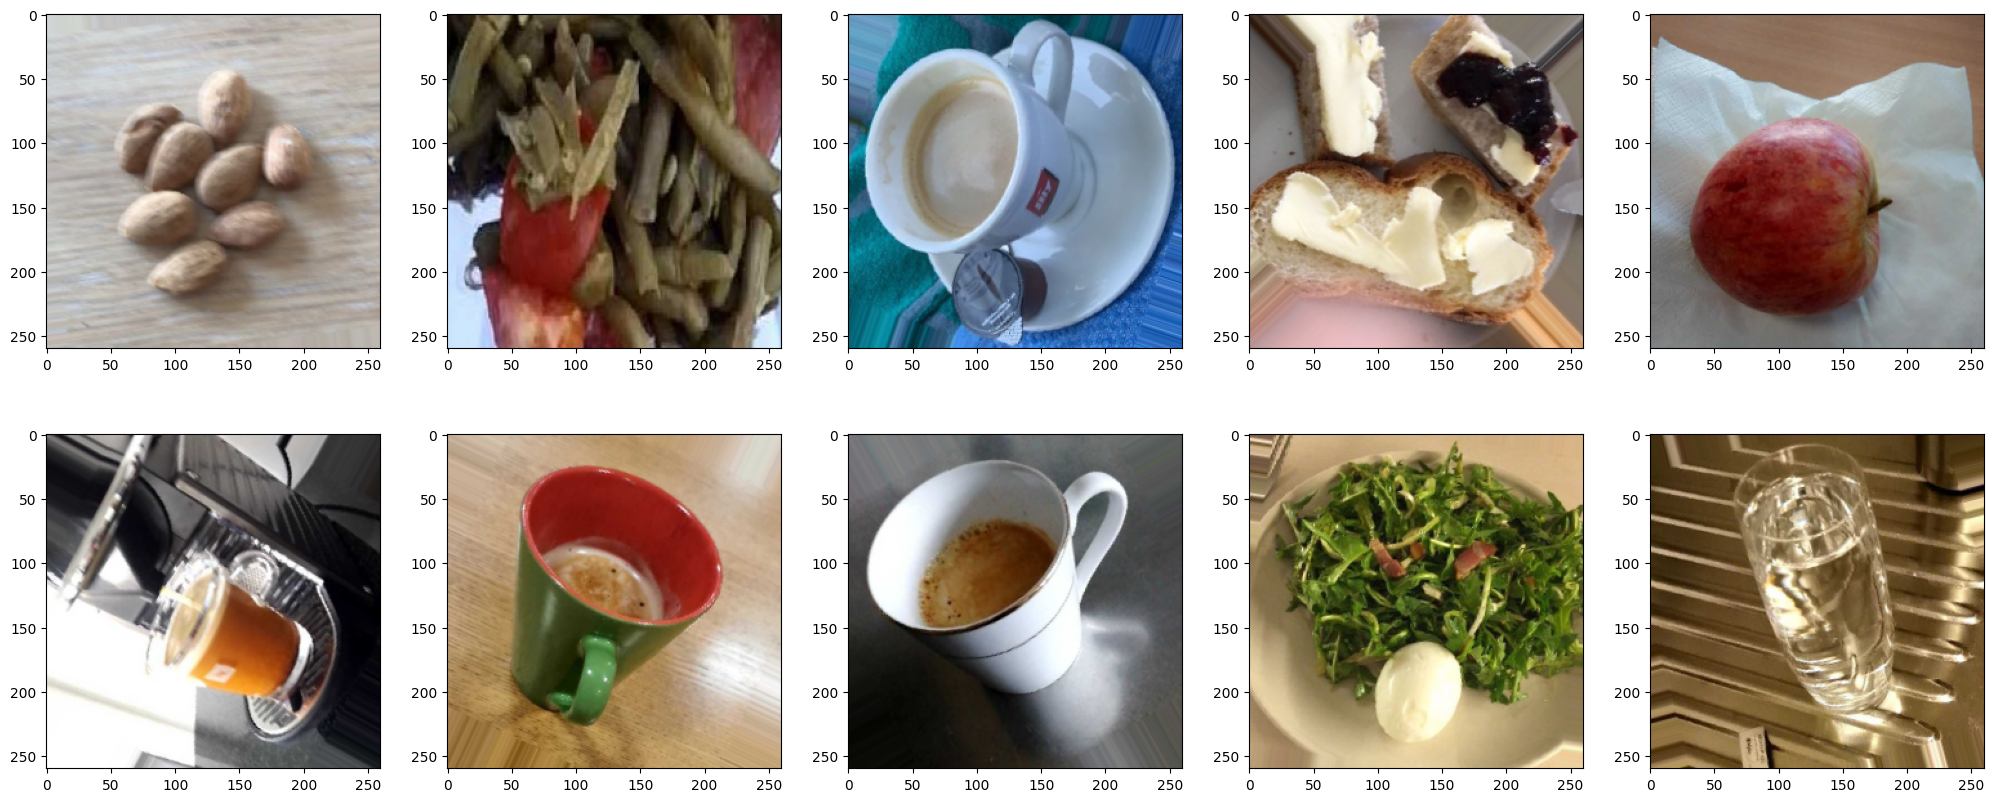

In [ ]:
# Show images of train-set

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
n = 0

for i in range(2):
  for j in range(5):
    img = train_generator.next()[0][n]
    ax[i][j].imshow(img)
    n += 1

## ANN Training

### Model Definition

Pada model ANN baseline untuk melakukan image classification, akan diguanakan hyperparameter sebagai berikut dengan alasan penggunaannya masing-masing.

- API : Sequential
- Model : Conv2D
- Activation : ReLU (Hidden layer) dan SoftMax (Output Layer)
- Jumlah layer : 3 (32, 64, dan 128 neuron). Digunakan peningkatan dalam jumlah neuron yang digunkan.
- loss : `categorical_crossentropy`. Loss ini digunakan dikarenakan target kelas dalam bentuk one-hot vector.
- Optimizer : Adam. Penggunaan optimizer adam pada baseline dikarenakan Adam merupakan optimizer paling populer dan optimal.

Metrics yang akan digunakan adalah accuracy. Metriks ini digunakan untuk dapat melihat akurasi dari model dalam memprediksi kelas hasil.



In [ ]:
# Clear Session
seed = 2
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Mendefinisikan input shape menyesuaikan besar gambar
input = (260, 260, 3)

In [ ]:
# Mendefinisikan model
model_base = tf.keras.models.Sequential()

# Convolution layer 1
model_base.add(Conv2D(32, (3,3), activation='relu', input_shape=input))
model_base.add(MaxPooling2D(2,2))
# Convolution layer 2
model_base.add(Conv2D(64, (3,3), activation='relu'))
model_base.add(MaxPooling2D(2,2))
# Convolution layer 3
model_base.add(Conv2D(128, (3,3), activation='relu')) # Layer konvolusi
model_base.add(MaxPooling2D(2,2))
model_base.add(GlobalAveragePooling2D())
# Hidden layer ANN
model_base.add(Dense(128, activation='relu'))
# Output layer
model_base.add(Dense(61, activation='softmax'))

In [ ]:
# Melihat summary model
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 129, 129, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [ ]:
# Compile model
model_base.compile(loss = 'categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

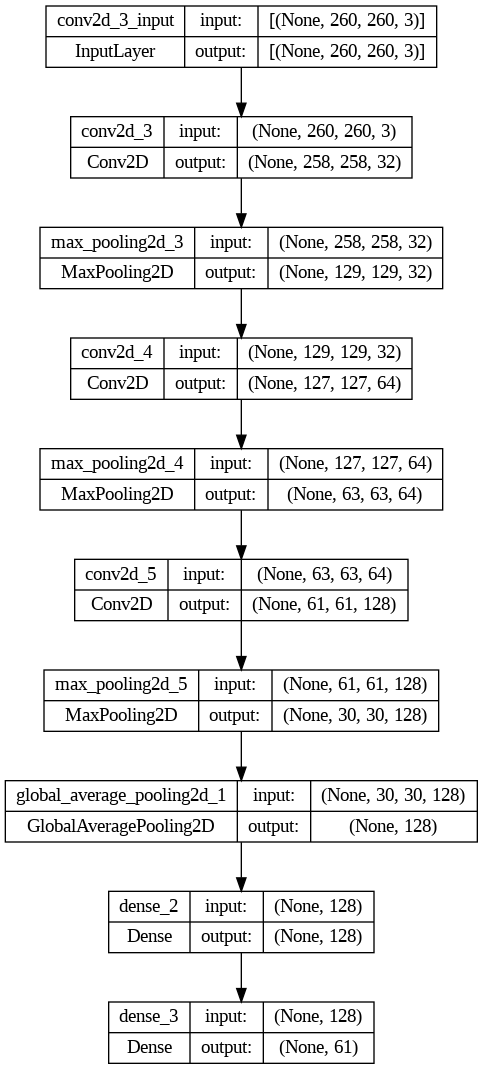

In [ ]:
# Plot layers
tf.keras.utils.plot_model(model_base, show_shapes=True)

### Model Training

In [ ]:
# Training Model
history = model_base.fit(train_generator,
                         epochs=25,
                         validation_data = val_generator)

Epoch 1/25
187/187 [==============================] - 143s 747ms/step - loss: 3.7629 - accuracy: 0.1113 - val_loss: 3.6688 - val_accuracy: 0.1227
Epoch 2/25
187/187 [==============================] - 131s 699ms/step - loss: 3.5837 - accuracy: 0.1421 - val_loss: 3.5236 - val_accuracy: 0.1555
Epoch 3/25
187/187 [==============================] - 133s 714ms/step - loss: 3.4343 - accuracy: 0.1612 - val_loss: 3.3833 - val_accuracy: 0.1736
Epoch 4/25
187/187 [==============================] - 150s 801ms/step - loss: 3.3610 - accuracy: 0.1681 - val_loss: 3.3376 - val_accuracy: 0.1702
Epoch 5/25
187/187 [==============================] - 133s 714ms/step - loss: 3.2940 - accuracy: 0.1793 - val_loss: 3.4395 - val_accuracy: 0.1649
Epoch 6/25
187/187 [==============================] - 132s 705ms/step - loss: 3.2440 - accuracy: 0.1872 - val_loss: 3.2531 - val_accuracy: 0.1991
Epoch 7/25
187/187 [==============================] - 133s 713ms/step - loss: 3.2103 - accuracy: 0.1933 - val_loss: 3.2643 -

### Model Evaluation

In [ ]:
# Membuat fungsi untuk menampilkan plot data
def plot_loss_acc(data, epoch):
    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    ax[0].plot(range(1,epoch+1),data.history['loss'],label='loss')
    ax[0].plot(range(1,epoch+1),data.history['val_loss'],label='val_loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')

    ax[1].plot(range(1,epoch+1),data.history['accuracy'],label='accuracy')
    ax[1].plot(range(1,epoch+1),data.history['val_accuracy'],label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')

    plt.show()

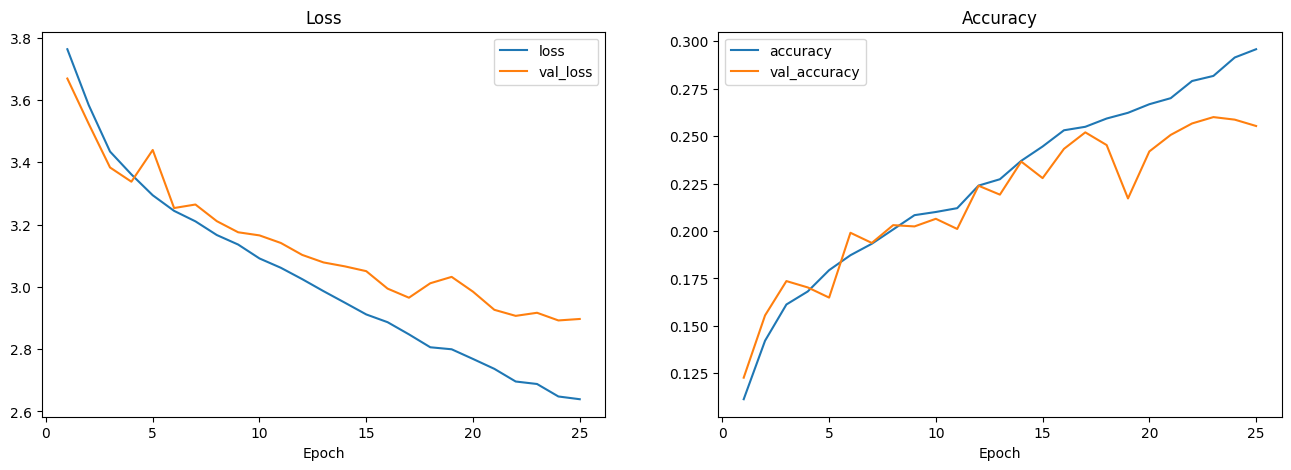

In [ ]:
# Melakukan plotting grafik history
plot_loss_acc(history, len(history.epoch))

In [ ]:
# Pengecekan metrics
model_base_test_result = model_base.evaluate(test_generator, verbose=0)
print(f'Test Loss       : {model_base_test_result[0]:.4f}')
print(f'Test Accuracy   : {model_base_test_result[1]:.4f}')

Test Loss       : 2.9502
Test Accuracy   : 0.2525


Dari grafik, dapat kita tarik beberapa insight :
- Dari nilai loss, kita dapat melihat peningkatan pada bagian akhir. Hal ini mengindikasikan bahwa model memburuk pada beberapa iterasi akhir. Ini dapat kita bantu cegah menggunakan Callback.
- Nilai akurasi menjadi stagnan pada validasi. Hal ini dapat terjadi karena overfitting atau dikarenakan model awal yang buruk. Kita dapat coba menggunakan Transfer Learning untuk mengimplementasikan model yang sudah baik.

Selain dari itu, kita dapat melakukan regularisasi yang mencakup Batch Normalization serta Dropout untuk membantu model belajar lebih baik.

## ANN Improvement

Pada Improvement, akan dibuat 3 model berbeda menyesuaikan dengan beberapa rekomendasi dari insight sebelumnya. Pendefinisian model akan didetailkan pada bagian selanjutnya.

### Model Definition

Pada improvement akan dibuat 3 model dengan baseline hyperparameter initial seperti sebelumnya yaitu : <br>
- API : Sequential
- Model : Conv2D
- Activation : ReLU (Hidden layer) dan SoftMax (Output Layer)
- Jumlah layer : 3 (32, 64, dan 128 neuron)
- loss : `categorical_crossentropy`
- Optimizer : Adam

Untuk kemudian dilakukan optimasi pada setiap model improvement sebagai berikut : <br>
1. Model 1 : Callback EarlyStopping. Seperti yang terlihat sebelumnya terjadi pengingkatan pada loss. Oleh karena itu akan diimplementasikan EarlyStopping dengan paremeter `Monitor` yaitu loss.
2. Model 2 : Batch Normalization.
3. Model 3 : Transfer Learning (MobileNet). Digunakan MobileNet dikarenakan model ini direkomendasikan untuk task image classification. Sumber : [Tutorialspoint](https://www.tutorialspoint.com/transfer-learning-with-convolutional-neural-networks#:~:text=Popular%20choices%20include%20VGG%2C%20ResNet,pre%2Dtrained%20model's%20learned%20features.)

Selain itu, ditambahkan dropout sebesar 20% untuk mengurangi neuron yang tidak memiliki signifikansi tinggi terhadap prediksi.

#### Model 1 - Callback

In [ ]:
# Mendefinisikan fungsi untuk clear session
def clear_session():
    seed = 2
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
# Mendefinisikan callback
callback = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [ ]:
# Mendefinisikan Model 1
Model_1 = tf.keras.models.Sequential()

# Convolution Layer 1
Model_1.add(Conv2D(32, (3,3), activation='relu', input_shape=input))
Model_1.add(MaxPooling2D(2,2))

# Convolution layer 2
Model_1.add(Conv2D(64, (3,3), activation='relu'))
Model_1.add(MaxPooling2D(2,2))
Model_1.add(Dropout(0.2))

# Convolution layer 3
Model_1.add(Conv2D(128, (3,3), activation='relu'))
Model_1.add(MaxPooling2D(2,2))
Model_1.add(GlobalAveragePooling2D())

# Output layer
Model_1.add(Dense(128, activation='relu'))
Model_1.add(Dense(61, activation='softmax'))

In [ ]:
# Melihat summary model
Model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 129, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       7

In [ ]:
# Melakukan compile
Model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

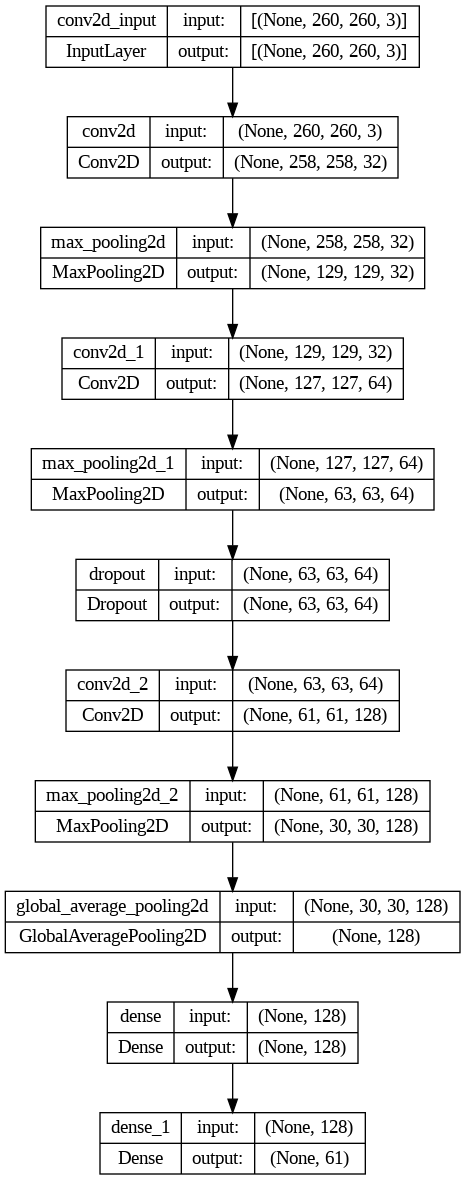

In [ ]:
# Plot layers
tf.keras.utils.plot_model(Model_1, show_shapes=True)

#### Model 2 - Batch Normalization

In [ ]:
# Membuat Model 2
Model_2 = tf.keras.models.Sequential()

# Convolution layer 1
Model_2.add(Conv2D(32, (3,3), activation='relu', input_shape = input))
Model_2.add(BatchNormalization())
Model_2.add(MaxPooling2D(2,2))

# Convolution layer 2
Model_2.add(Conv2D(64, (3,3), activation='relu'))
Model_2.add(BatchNormalization())
Model_2.add(MaxPooling2D(2,2))

# Convolution layer 3
Model_2.add(Conv2D(128, (3,3), activation='relu'))
Model_2.add(BatchNormalization())
Model_2.add(MaxPooling2D(2,2))
Model_2.add(Flatten())

# Output layer
Model_2.add(Dense(128, activation='relu'))
Model_2.add(Dense(61, activation='softmax'))

In [ ]:
# Menampilkan summary Model 2
Model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 258, 258, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 258, 258, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 129, 129, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 127, 127, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
# Melakukan compile model 2
Model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

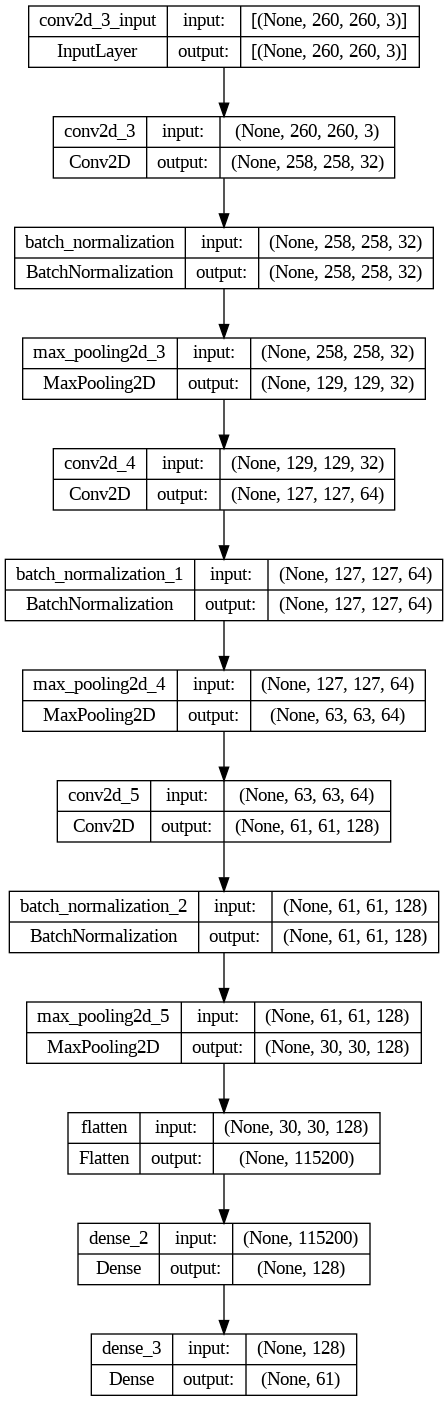

In [ ]:
# Melakukan plotting model
plot_model(Model_2, show_shapes=True)

#### Model 3 - Transfer Learning

In [ ]:
# Melakukan loading transfer model menggunakan MobileNetV2
base_transfer_model = tf.keras.applications.MobileNetV2(input_shape=input,
                                                       pooling='avg',
                                                       weights= None,
                                                       include_top=False)

In [ ]:
# Mendefinisikan callback
callback3 = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)]

In [ ]:
# Membuat model 3
Model_3 = tf.keras.models.Sequential()
# Menambahkan transfer model
Model_3.add(base_transfer_model)
# Menambahkan output layer
Model_3.add(Dense(128, activation='relu'))
Model_3.add(Dense(61, activation='softmax'))

In [ ]:
# Melihat summary model 3
Model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_260 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 61)                7869      
                                                                 
Total params: 2429821 (9.27 MB)
Trainable params: 2395709 (9.14 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Melakukan compile untuk model 3
Model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

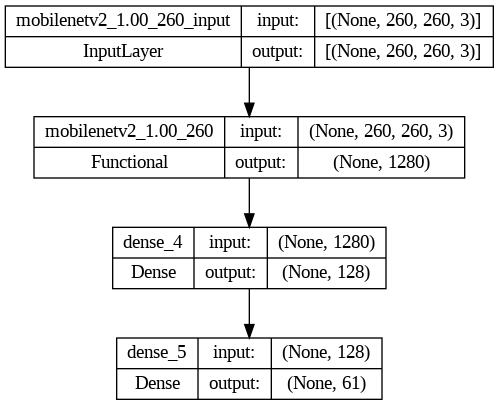

In [ ]:
# Melakukan plotting model
plot_model(Model_3, show_shapes=True)

### Model Training

In [ ]:
# Kalau butuh clear session
clear_session()

In [ ]:
# Melakukan training untuk model 1
history_model_1 =Model_1.fit(train_generator,
            epochs=25,
            validation_data = val_generator,
            callbacks = callback)

Epoch 1/25
187/187 [==============================] - 174s 883ms/step - loss: 3.7736 - accuracy: 0.1021 - val_loss: 3.6839 - val_accuracy: 0.1092
Epoch 2/25
187/187 [==============================] - 164s 877ms/step - loss: 3.5884 - accuracy: 0.1420 - val_loss: 3.5214 - val_accuracy: 0.1488
Epoch 3/25
187/187 [==============================] - 149s 797ms/step - loss: 3.4238 - accuracy: 0.1631 - val_loss: 3.3574 - val_accuracy: 0.1709
Epoch 4/25
187/187 [==============================] - 138s 737ms/step - loss: 3.3226 - accuracy: 0.1809 - val_loss: 3.3349 - val_accuracy: 0.1930
Epoch 5/25
187/187 [==============================] - 140s 747ms/step - loss: 3.2560 - accuracy: 0.1907 - val_loss: 3.2561 - val_accuracy: 0.1991
Epoch 6/25
187/187 [==============================] - 137s 735ms/step - loss: 3.1962 - accuracy: 0.1981 - val_loss: 3.2464 - val_accuracy: 0.1937
Epoch 7/25
187/187 [==============================] - 139s 747ms/step - loss: 3.1470 - accuracy: 0.2060 - val_loss: 3.2270 -

In [ ]:
# Melakukan training untuk model 2
history_model_2 =Model_2.fit(train_generator,
            epochs=25,
            validation_data = val_generator,
            callbacks = callback)

Epoch 1/25
187/187 [==============================] - 136s 711ms/step - loss: 5.9164 - accuracy: 0.0738 - val_loss: 20.8450 - val_accuracy: 0.0811
Epoch 2/25
187/187 [==============================] - 132s 705ms/step - loss: 4.0575 - accuracy: 0.0922 - val_loss: 5.1543 - val_accuracy: 0.0838
Epoch 3/25
187/187 [==============================] - 133s 712ms/step - loss: 4.0371 - accuracy: 0.0917 - val_loss: 9.6097 - val_accuracy: 0.0610
Epoch 4/25
187/187 [==============================] - 132s 704ms/step - loss: 3.9512 - accuracy: 0.0945 - val_loss: 8.4041 - val_accuracy: 0.0409
Epoch 5/25
187/187 [==============================] - 134s 719ms/step - loss: 3.8757 - accuracy: 0.0940 - val_loss: 4.6115 - val_accuracy: 0.0784
Epoch 6/25
187/187 [==============================] - 133s 710ms/step - loss: 3.8142 - accuracy: 0.1038 - val_loss: 3.8159 - val_accuracy: 0.0838
Epoch 7/25
187/187 [==============================] - 131s 699ms/step - loss: 3.7845 - accuracy: 0.1121 - val_loss: 5.2401 

In [ ]:
# Melakukan training untuk Model 3
history_model_3 = Model_3.fit(train_generator,
            epochs = 25,
            validation_data = val_generator,
            callbacks = callback3)

Epoch 1/25
187/187 [==============================] - 171s 759ms/step - loss: 3.7386 - accuracy: 0.1230 - val_loss: 3.9758 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 2/25
187/187 [==============================] - 156s 838ms/step - loss: 3.4703 - accuracy: 0.1673 - val_loss: 3.9814 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 3/25
187/187 [==============================] - 141s 752ms/step - loss: 3.3073 - accuracy: 0.1913 - val_loss: 4.2382 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 4/25
187/187 [==============================] - 142s 761ms/step - loss: 3.1753 - accuracy: 0.2057 - val_loss: 4.4728 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 5/25
187/187 [==============================] - 140s 747ms/step - loss: 3.0836 - accuracy: 0.2174 - val_loss: 4.7664 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 6/25
187/187 [==============================] - 142s 758ms/step - loss: 2.9827 - accuracy: 0.2352 - val_loss: 5.3565 - val_accuracy: 0.0536 - lr: 0.0010
Epoch 7/25
187/187 [==========================

### Model Evaluation

#### Model 1

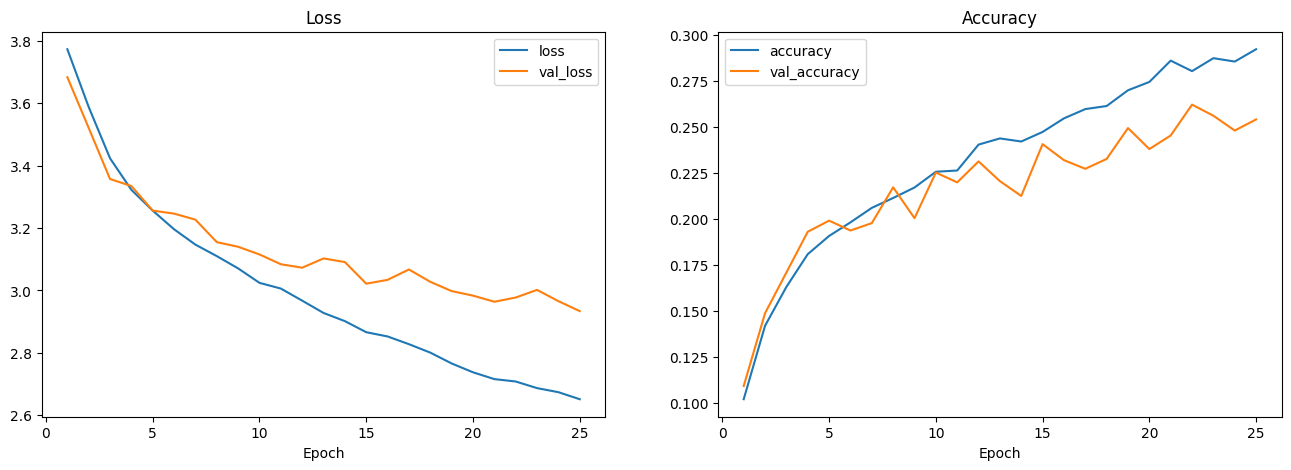

In [ ]:
# Evaluasi model 1
plot_loss_acc(history_model_1, len(history_model_1.epoch))

In [ ]:
# Pengecekan metrics
model_1_test_result = Model_1.evaluate(test_generator, verbose=0)
print(f'Test Loss       : {model_1_test_result[0]:.4f}')
print(f'Test Accuracy   : {model_1_test_result[1]:.4f}')

Test Loss       : 2.9288
Test Accuracy   : 0.2617


Pada hasil Model 1, daopat terlihat grafik validasi yang cukup menyesuaikan dengan hasil train. Dapat terlihat pada akhir ke-stagnan-an dari hasil validasi. Hal ini mengindikasikan bahwa model sudah tidak dapat belajar lebih lanjut lagi.

#### Model 2

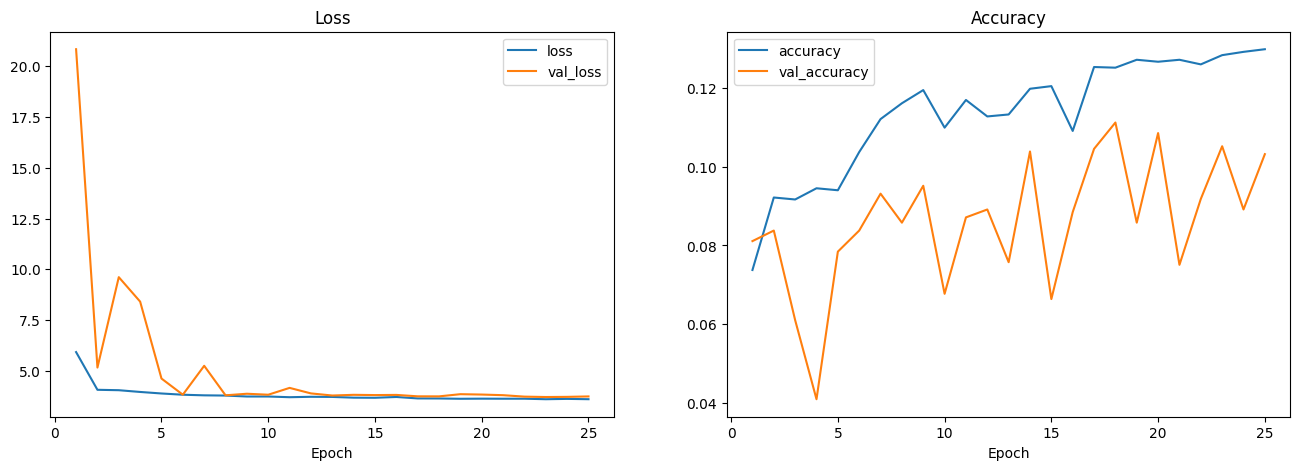

In [ ]:
# Evaluasi model 2
plot_loss_acc(history_model_2, len(history_model_2.epoch))

In [ ]:
# Pengecekan metrics
model_2_test_result = Model_2.evaluate(test_generator, verbose=0)
print(f'Test Loss       : {model_2_test_result[0]:.4f}')
print(f'Test Accuracy   : {model_2_test_result[1]:.4f}')

Test Loss       : 3.6571
Test Accuracy   : 0.1147


Pada hasil Model 2, dapat terlihat ledakan accuracy dimana tidak terlalu terlihat trend peningkatan maupun penurunan. Dari hasil loss juga terlihat cukup datar dan tidak ada penurunan dari loss train. Hal ini mengindikasikan learning rate yang terlalu tinggi atau gradient problem.

#### Model 3

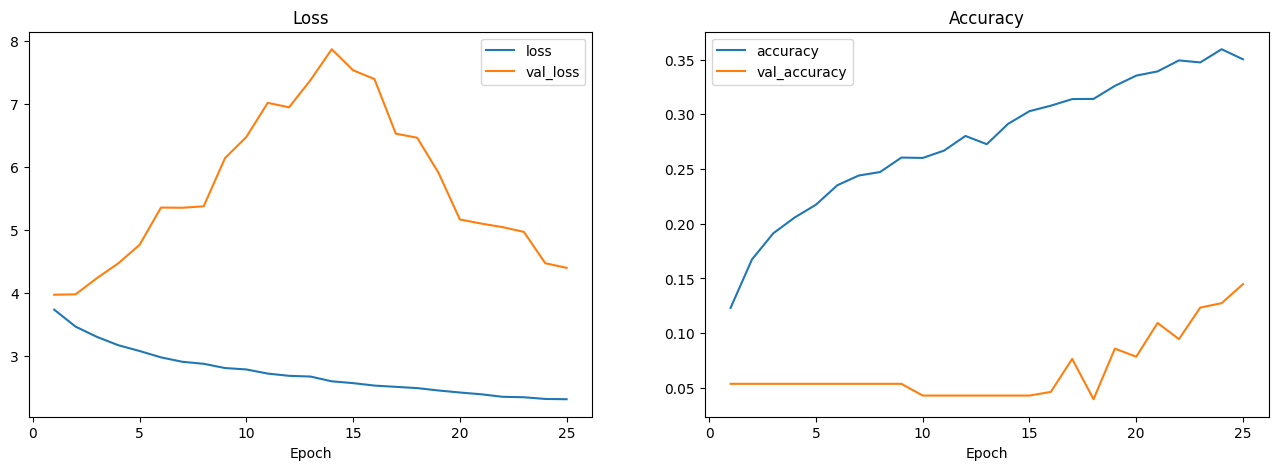

In [ ]:
# Evaluasi model 3
plot_loss_acc(history_model_3, len(history_model_3.epoch))

In [ ]:
# Pengecekan metrics
model_3_test_result = Model_3.evaluate(test_generator, verbose=0)
print(f'Test Loss       : {model_3_test_result[0]:.4f}')
print(f'Test Accuracy   : {model_3_test_result[1]:.4f}')

Test Loss       : 4.4187
Test Accuracy   : 0.1485


Hasil pada Model 3 dapat terlihat kejanggalan dimana nilai val_loss jauh meningkat pada iterasi epoch awal dan kemudian menurun seperti membentuk gunung. Hal ini dapat dikarenakan ketidakcocokan terhadap arsitektur transfer learning yang digunakan. Untuk selanjutnya dapat dicoba arsitektur transfer learning lainnya.

#### Kesimpulan

Dari ketiga model, jika dilakukan perbandingan terhadap Model Baseline, didapatkan hasil sebagai berikut.

| Metrics | Baseline Model | Model 1 | Model 2 | Model 3 |
| --- | --- | --- | --- | ---|
| Test Loss | 2.9502 | 2.9288 | 3.6571 | 4.4187 |
| Test Accuracy | 0.2525 | 0.2617 | 0.1147 | 0.1485 |

Berdasarkan hasil, kita dapat melihat bahwa Model 1 memiliki nilai akurasi terbaik. Namun, keseluruhan akurasi dari keempat model semuanya cukup buruk dengan akurasi < 50%. Selanjutnya kita akan melakukan analisis lebih lanjut dengan melihat classification report dari model terpilih.

In [ ]:
# Menentukan model yang terpilih
chosen_model = Model_1

#### Classification Report
Dilakukan analisis classification report lebih lanjut terhadap model terpilih.

In [ ]:
# Melakukan mapping terhadap class name agar dapat diproses classification report
dat_test['ClassMap'] = dat_test['ClassName'].map(test_generator.class_indices)

In [ ]:
# Mengambil y dari test set untuk dilakukan perbandingan
y_tes = dat_test['ClassMap']

In [ ]:
# Evaluasi test-set

result = chosen_model.evaluate(test_generator)
result

59/59 [==============================] - 32s 532ms/step - loss: 2.9297 - accuracy: 0.2611


[2.929739236831665, 0.26112601161003113]

In [ ]:
# Mengecek perfroma dari test-set

# Mengambil probabilitas kelas
y_pred_proba = chosen_model.predict(test_generator)

# Mengambil kelas dengan probabilitas tertinggi
y_pred_food = np.argmax(y_pred_proba, axis=-1)

59/59 [==============================] - 32s 543ms/step


In [ ]:
# Menampilkan Classification Report
print(classification_report(y_tes, y_pred_food, target_names=np.array(class_names)))

                                   precision    recall  f1-score   support

                            water       0.00      0.00      0.00        11
           pizza-margherita-baked       0.23      0.41      0.30        32
                         broccoli       0.33      0.05      0.09        20
           salad-leaf-salad-green       0.48      0.31      0.37        36
                              egg       0.00      0.00      0.00        15
                           butter       0.00      0.00      0.00        11
                      bread-white       0.00      0.00      0.00        15
                            apple       0.00      0.00      0.00        10
                   dark-chocolate       0.00      0.00      0.00        20
       white-coffee-with-caffeine       0.20      0.66      0.31       122
                     sweet-pepper       0.00      0.00      0.00        15
mixed-salad-chopped-without-sauce       0.18      0.13      0.15        77
                     tom

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dari Classificaiton report, dapat terlihat model memiliki nilai prediksi tertinggi pada kelas `tomato-sauce`. Hal ini dapat memberikan hasil yang condong terhadap kelas ini pada proses prediksi inferensi.

## Addition Resource
Untuk memenuhi kebutuhan kalori tracker, akan dibuat sebuah dataframe kalori terhadap setiap class yang tersedia. Data disesuaikan dengan jumlah dan indexing kelas.

In [ ]:
# Melakukan inputing data pada dictionary
data_kalori = {
    'class' : list(train_generator.class_indices.keys()),
    'kalori' : [576, 52, 322, 89, 43, 353, 190, 361, 120, 361, 247, 247, 34, 717,
                41, 402, 239, 312, 120, 70, 406, 60, 230, 155, 9, 31, 413, 145, 120, 304,
                260, 23, 53, 680, 607, 15, 25, 40, 420, 158, 12, 266, 87, 130, 15, 336, 208,
                100, 330, 32, 31, 0, 0, 18, 82, 0, 0, 1, 85, 82, 17]
}
# Membuat dataset kalori
df_kalori = pd.DataFrame(data_kalori)
df_kalori

class  kalori
0                      almonds     576
1                        apple      52
2                      avocado     322
3                       banana      89
4                         beer      43
..                         ...     ...
56               water-mineral       0
57  white-coffee-with-caffeine       1
58                    wine-red      85
59                  wine-white      82
60                    zucchini      17

[61 rows x 2 columns]

Kemudian, kita buat function untuk melakukan prediksi model.

In [ ]:
# Membuat function untuk melakukan prediksi
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(260, 260))
  x = tf.keras.utils.img_to_array(img)/255

  plt.imshow(img)

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = chosen_model.predict(images, batch_size=10)
  idx = np.argmax(classes)
  clas = list(train_generator.class_indices.keys())
  print('Prediction is a {}'.format(clas[idx]))
  print('Kalori :', df_kalori['kalori'][idx])

## Model Saving

In [ ]:
# Mendefinsikan model terpilih
chosen_model = Model_1

In [ ]:
# Melihat summary dari model terpilih
chosen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 129, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       7

In [ ]:
# Freeze model

chosen_model.trainable = False
chosen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 129, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       7

In [ ]:
# Save Model

chosen_model.save('food_cnn_model1.keras')
Model_1.save('food_cnn_model1.h5') # Percobaan penyimpanan ke dalam h5 untuk deployment

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Export csv
# Dataframe train df
train_df.to_csv('food_classif.csv', index=False)
# Dataframe kalori
df_kalori.to_csv('food_classif_kalori.csv', index = False)

In [ ]:
# Export fungsi
%%writefile food_classif_pred.py
# Import related library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function untuk prediksi data
def prediction(file, chosen_model, df_kalori):
    img = tf.keras.utils.load_img(file, target_size=(260, 260))
    x = tf.keras.utils.img_to_array(img)/255

    plt.imshow(img)

    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = chosen_model.predict(images, batch_size=10)
    idx = np.argmax(classes)
    clas = ['almonds','apple','avocado','banana','beer','biscuits','boisson-au-glucose-50g','bread-french-white-flour','bread-sourdough',
            'bread-white','bread-whole-wheat','bread-wholemeal','broccoli','butter','carrot','cheese','chicken','chips-french-fries','coffee-with-caffeine','corn','croissant','cucumber','dark-chocolate',
            'egg','espresso-with-caffeine','french-beans','gruyere','ham-raw','hard-cheese','honey','jam','leaf-spinach','mandarine','mayonnaise','mixed-nuts',
            'mixed-salad-chopped-without-sauce','mixed-vegetables','onion','parmesan','pasta-spaghetti','pickle','pizza-margherita-baked','potatoes-steamed','rice',
            'salad-leaf-salad-green','salami','salmon','sauce-savoury','soft-cheese','strawberries','sweet-pepper','tea','tea-green','tomato','tomato-sauce',
            'water','water-mineral','white-coffee-with-caffeine','wine-red','wine-white','zucchini']
    print('Prediction is a {}'.format(clas[idx]))
    print('Kalori :', df_kalori['kalori'][idx])

Writing food_classif_pred.py


## Model Inference

1/1 [==============================] - 0s 39ms/step
Prediction is a cheese
Kalori : 402


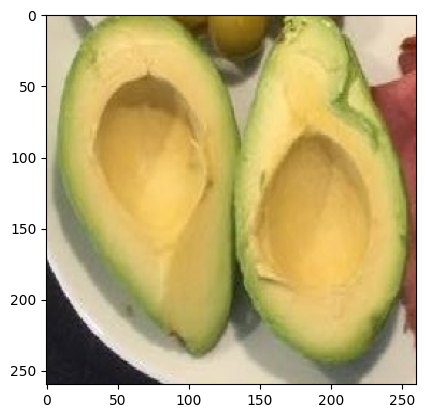

In [ ]:
# Melakukan prediksi terhadap test set
prediction('/content/test_images/test_images/1064b4277e.jpg')

Dari model dapat terlihat bahwa gambar terprediksi sebagai `cheese` dengan kalori sebesar 402 kal. Walaupun jika terlihat dengan mata manusia, gambar termasuk ke dalam kelas `avocado`. Hal ini dikarenakan nilai precision dari prediksi kelas `avocado` sebesar 0.00 atau belum ada yang tepat. Hal ini dapat menjadi perbaikan untuk menambahkan image avocado pada training selanjutnya.

1/1 [==============================] - 0s 30ms/step
Prediction is a salad-leaf-salad-green
Kalori : 15


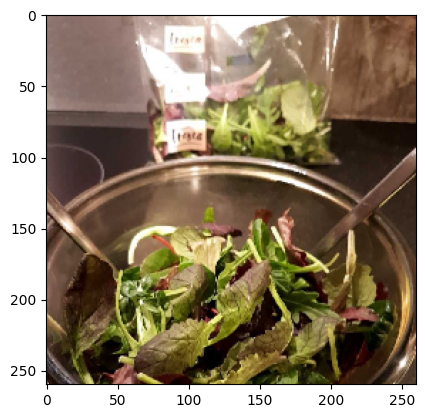

In [ ]:
# Melakukan prediksi terhadap test set
prediction('/content/test_images/test_images/2b78d749e7.jpg')

Dari model dapat terlihat bahwa gambar terprediksi sebagai `salad-leaf-salad-green` dengan kalori sebesar 15 kal. Jika terlihat dengan mata manusia, gambar sudah terkategorikan secara benar. Hal ini dikarenakan nilai precision dari prediksi kelas `salad-leaf-salad-green` pada nilai 0.48 (kisaran 48%) yang sudah cukup lebih tinggi dari kelas lainnya.

## Kesimpulan

Dengan tujuan membuat model CNN untuk melakukan identifikasi gambar serta tracking kalori, didapatkan insight sebagai berikut:
- Digunakan multiclass labeling terhadap data food dengan 61 jenis kelas.
- Dapat terlihat bahwa pembagian label dari dataset tidak merata, hal ini dapat meningkatkan bias atau tingkat ketepatan model pada kelas tertentu.
- Base model dibuat menggunaklan model sequential dan 4 hidden layer (3 convolution dan 1 ann)
- Dilakukan tuning dengan 3 model menggunakan callback, batch normalization, dan transfer learning yang menghasilkan hasil sebagai berikut.

| Metrics | Baseline Model | Model 1 | Model 2 | Model 3 |
| --- | --- | --- | --- | ---|
| Test Loss | 2.9502 | 2.9288 | 3.6571 | 4.4187 |
| Test Accuracy | 0.2525 | 0.2617 | 0.1147 | 0.1485 |

- Seluruh model mengalami underfit dikarenakan nilai akurasi yang rendah (< 50%).
- Dari classification report, didapatkan bias terhadap kelas `tomato-sauce` yang memiliki nilai precision 1. Hal ini dapat memberikan bias pada proses prediksi model.
- Keterbatasan GPU menyebabkan proses training yang cukup lama dan mengurangi kesempatan dalam mencoba berbagai campuran hyperparameter lainnya.

**Next Steps**

Melakukan percobaan terhadap hyperparameter lain, mencoba menggunakan transfer learning untuk CNN jenis lainnya, dan dapat dicoba menambahkan hidden layer pada model untuk meningkatkan akurasi. Selain itu, untuk meningkatkan presisi terhadap kelas-kelas yang memiliki presisi rendah, dapat dilakukan penambahan image kelas tersebut pada training set selanjutnya.
